In [1]:
!pip install cassandra-driver pandas requests  # Install required libraries

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 45.1 MB/s eta 0:00:00


In [24]:
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
import json

# This secure connect bundle is autogenerated when you download your SCB,
# if yours is different update the file name below
cloud_config= {
  'secure_connect_bundle': 'secure-connect-warehouse-sales.zip'
}

# This token JSON file is autogenerated when you download your token,
# if yours is different update the file name below
with open("warehouse_sales-token.json") as f:
    secrets = json.load(f)

CLIENT_ID = secrets["clientId"]
CLIENT_SECRET = secrets["secret"]

auth_provider = PlainTextAuthProvider(CLIENT_ID, CLIENT_SECRET)
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect()

row = session.execute("select release_version from system.local").one()
if row:
  print(row[0])
else:
  print("An error occurred.")

4.0.11-3a52ecb0d31d


In [4]:
import requests
import pandas as pd

url = "https://data.montgomerycountymd.gov/api/views/v76h-r7br/rows.json?accessType=DOWNLOAD"
response = requests.get(url)
data = response.json()

# Convert to Pandas DataFrame
rows = data.get('data', [])
columns = [col['name'] for col in data['meta']['view']['columns']]
df = pd.DataFrame(rows, columns=columns)

In [6]:
df.columns

Index(['sid', 'id', 'position', 'created_at', 'created_meta', 'updated_at',
       'updated_meta', 'meta', 'YEAR', 'MONTH', 'SUPPLIER', 'ITEM CODE',
       'ITEM DESCRIPTION', 'ITEM TYPE', 'RETAIL SALES', 'RETAIL TRANSFERS',
       'WAREHOUSE SALES'],
      dtype='object')

In [7]:
from cassandra.query import BatchStatement
import pandas as pd
import uuid
from datetime import datetime
import requests

In [8]:
session.execute(f"""
CREATE TABLE IF NOT EXISTS sales.Bronze (
    id UUID PRIMARY KEY,
    year INT,
    month INT,
    supplier TEXT,
    item_code TEXT,
    item_description TEXT,
    item_type TEXT,
    retail_sales DECIMAL,
    retail_transfers DECIMAL,
    warehouse_sales DECIMAL,
    created_at TIMESTAMP
);
""")

In [10]:
insert_stmt = session.prepare(f"""
INSERT INTO sales.Bronze (
    id, year, month, supplier, item_code, item_description,
    item_type, retail_sales, retail_transfers, warehouse_sales, created_at
) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
""")


In [11]:
batch_size = 1000
batch = BatchStatement()
inserted_count = 0

In [12]:
from tqdm import tqdm
def insert_rows(dataframe, total_rows, batch_size):
    inserted = 0
    with tqdm(total=total_rows, desc="Inserting rows") as pbar:
        for i in range(0, total_rows, batch_size):
            batch = BatchStatement()
            end_idx = min(i + batch_size, total_rows)

            for _, row in dataframe.iloc[i:end_idx].iterrows():
                try:
                    batch.add(insert_stmt, (
                        uuid.uuid4(),
                        int(row['YEAR']),
                        int(row['MONTH']),
                        str(row['SUPPLIER']),
                        str(row['ITEM CODE']),
                        str(row['ITEM DESCRIPTION']),
                        str(row['ITEM TYPE']),
                        float(row['RETAIL SALES']),
                        float(row['RETAIL TRANSFERS']),
                        float(row['WAREHOUSE SALES']),
                        datetime.now()
                    ))
                except Exception as e:
                    print(f"Skipping row {i} due to error: {str(e)}")
                    continue

            session.execute(batch)
            inserted += (end_idx - i)
            pbar.update(end_idx - i)

    return inserted

# Execute the insertion
success_count = insert_rows(df, 120000, batch_size)
print(f"Total rows inserted: {success_count}")

Inserting rows:  15%|█▌        | 18000/120000 [00:11<01:05, 1568.68it/s]

Skipping row 18000 due to error: float() argument must be a string or a real number, not 'NoneType'


Inserting rows: 100%|██████████| 120000/120000 [01:15<00:00, 1584.18it/s]

Total rows inserted: 120000


In [21]:
result = session.execute(f"SELECT COUNT(*) FROM sales.Bronze").one()
print(f"\nSuccessfully inserted {success_count} rows")
cluster.shutdown()


Successfully inserted 120000 rows


In [46]:
df = session.execute(f"SELECT * FROM sales.Bronze")

In [48]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from decimal import Decimal
import uuid
from datetime import datetime

# Create Spark Session
spark = SparkSession.builder \
    .appName("CassandraToSpark") \
    .getOrCreate()

# Function to properly extract data from Cassandra rows
def convert_cassandra_row(row):
    return {
        'id': str(row.id) if row.id else None,
        'created_at': row.created_at if row.created_at else None,
        'item_code': row.item_code if row.item_code else None,
        'item_description': row.item_description if row.item_description else None,
        'item_type': row.item_type if row.item_type else None,
        'month': int(row.month) if row.month else None,
        'retail_sales': float(row.retail_sales) if row.retail_sales else None,
        'retail_transfers': float(row.retail_transfers) if row.retail_transfers else None,
        'supplier': row.supplier if row.supplier else None,
        'warehouse_sales': float(row.warehouse_sales) if row.warehouse_sales else None,
        'year': int(row.year) if row.year else None
    }

# Convert all rows
data = [convert_cassandra_row(row) for row in df]

# Define schema
schema = StructType([
    StructField("id", StringType(), True),
    StructField("created_at", TimestampType(), True),
    StructField("item_code", StringType(), True),
    StructField("item_description", StringType(), True),
    StructField("item_type", StringType(), True),
    StructField("month", IntegerType(), True),
    StructField("retail_sales", DoubleType(), True),
    StructField("retail_transfers", DoubleType(), True),
    StructField("supplier", StringType(), True),
    StructField("warehouse_sales", DoubleType(), True),
    StructField("year", IntegerType(), True)
])

# Create DataFrame
spark_df = spark.createDataFrame(data, schema=schema)

# Show results
spark_df.show(5, truncate=False)

+------------------------------------+-----------------------+---------+-------------------------------------+---------+-----+------------+----------------+-------------------------+---------------+----+
|id                                  |created_at             |item_code|item_description                     |item_type|month|retail_sales|retail_transfers|supplier                 |warehouse_sales|year|
+------------------------------------+-----------------------+---------+-------------------------------------+---------+-----+------------+----------------+-------------------------+---------------+----+
|f491cc81-d3da-4ddd-8170-5a0dac0b21d1|2025-05-04 00:54:49.9  |83627    |BOTA BOX S/BLANC - 3L                |WINE     |9    |96.89       |102.0           |DELICATO FAMILY VINEYARDS|25.0           |2017|
|02b3eba1-1f15-4d6e-b25d-d3b9d1ce8ce3|2025-05-04 00:54:03.876|325882   |GINI SOAVE - 750ML                   |WINE     |7    |NULL        |NULL            |BACCHUS IMPORTERS LTD    |1.

### Bronze Layer

In [50]:
# Cache the DataFrame for better performance
spark_df.cache()

# 1. Basic Exploration
print("Record Count:", spark_df.count())
spark_df.printSchema()
spark_df.show(5, vertical=True)

# 2. Data Quality Checks
from pyspark.sql.functions import col, count, when, isnull

# Null check per column
null_checks = spark_df.select(
    [count(when(isnull(c), c)).alias(c) for c in spark_df.columns]
)
null_checks.show()

# 3. Basic Cleaning (Bronze Layer Standards)
bronze_df = spark_df.withColumnRenamed("supplier", "supplier_name") \
    .withColumn("ingestion_timestamp", current_timestamp()) \
    .withColumn("data_source", lit("cassandra.sales.Bronze"))



Record Count: 94999
root
 |-- id: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- item_code: string (nullable = true)
 |-- item_description: string (nullable = true)
 |-- item_type: string (nullable = true)
 |-- month: integer (nullable = true)
 |-- retail_sales: double (nullable = true)
 |-- retail_transfers: double (nullable = true)
 |-- supplier: string (nullable = true)
 |-- warehouse_sales: double (nullable = true)
 |-- year: integer (nullable = true)

-RECORD 0--------------------------------
 id               | f491cc81-d3da-4dd... 
 created_at       | 2025-05-04 00:54:... 
 item_code        | 83627                
 item_description | BOTA BOX S/BLANC ... 
 item_type        | WINE                 
 month            | 9                    
 retail_sales     | 96.89                
 retail_transfers | 102.0                
 supplier         | DELICATO FAMILY V... 
 warehouse_sales  | 25.0                 
 year             | 2017                 
-RECORD

### Silver Layer

In [52]:
from pyspark.sql.functions import col

# Remove invalid rows where 'year', 'month', or key fields are zero
silver_df = spark_df.filter(
    (col("year") != 0) &
    (col("month") != 0) &
    (col("id") != "0") &
    (col("item_code") != "0") &
    (col("item_type") != "0") &
    (col("supplier") != "0")
)
silver_df = silver_df.dropDuplicates(["id"]) \
    .filter(
        (col("retail_sales") >= 0) &
        (col("warehouse_sales") >= 0)
    ) \
    .na.fill({
        "item_description": "Unknown",
        "supplier": "Unknown"
    }) \
    .filter(col("id").isNotNull())


In [53]:
silver_df.show()

+--------------------+--------------------+---------+--------------------+-----------+-----+------------+----------------+--------------------+---------------+----+
|                  id|          created_at|item_code|    item_description|  item_type|month|retail_sales|retail_transfers|            supplier|warehouse_sales|year|
+--------------------+--------------------+---------+--------------------+-----------+-----+------------+----------------+--------------------+---------------+----+
|000285b1-73da-416...|2025-05-04 00:55:...|    23024|LANDSHARK LAGER 2...|       BEER|   11|         7.0|             8.0|  ANHEUSER BUSCH INC|           89.0|2017|
|0003da6f-a008-48f...|2025-05-04 00:54:...|   342116|HONORO VERA GARNA...|       WINE|    7|        4.35|             8.0|REPUBLIC NATIONAL...|            9.0|2017|
|00058f00-cbe3-4a7...|2025-05-04 00:55:...|   346692|GAME OF THRONES C...|       WINE|   11|        9.74|             8.0|VINTAGE WINE ESTA...|            4.0|2017|
|0005f598-

### Gold Layer

In [54]:
agg1 = silver_df.groupBy("year") \
    .sum("retail_sales") \
    .withColumnRenamed("sum(retail_sales)", "total_retail_sales")
agg1.show()

+----+------------------+
|year|total_retail_sales|
+----+------------------+
|2020|175472.93000000127|
|2017|369558.92000000086|
+----+------------------+



In [55]:
agg2 = silver_df.groupBy("year", "month", "item_code") \
    .sum("retail_sales") \
    .withColumnRenamed("sum(retail_sales)", "monthly_retail_sales")
agg2.show()

+----+-----+---------+--------------------+
|year|month|item_code|monthly_retail_sales|
+----+-----+---------+--------------------+
|2017|    7|    64742|                14.3|
|2017|    9|   381756|                0.08|
|2017|   10|    27646|                0.25|
|2017|    6|   311407|                0.16|
|2020|    1|   302562|                0.42|
|2020|    3|   313629|                0.99|
|2017|    8|    57312|                2.03|
|2017|    6|   438804|                0.16|
|2017|    6|   421758|                0.65|
|2020|    3|   241318|                9.92|
|2017|    9|    84599|                7.08|
|2020|    1|    84204|               15.86|
|2020|    7|    76031|               17.99|
|2017|    8|    41002|                1.66|
|2020|    7|    51153|                0.41|
|2017|    7|    45163|                0.57|
|2017|   10|    23612|                8.77|
|2020|    1|    83370|               22.58|
|2020|    1|    80911|              109.65|
|2020|    7|    28741|          

In [56]:
from pyspark.sql.functions import sum

agg3 = silver_df.groupBy("item_code") \
    .agg(sum("warehouse_sales").alias("total_warehouse_sales")) \
    .orderBy(col("total_warehouse_sales").desc()) \
    .limit(5)
agg3.show()

+---------+---------------------+
|item_code|total_warehouse_sales|
+---------+---------------------+
|    23445|    78217.79164000001|
|    96750|          70369.95832|
|    23886|          60078.04166|
|    96741|          52612.16663|
|    90590|   50479.300010000006|
+---------+---------------------+



In [57]:
from pyspark.sql.functions import avg

agg4 = silver_df.groupBy("item_type") \
    .agg(avg("retail_transfers").alias("avg_retail_transfers"))
agg4.show()

+-----------+--------------------+
|  item_type|avg_retail_transfers|
+-----------+--------------------+
|       WINE|  14.299368589316593|
|     LIQUOR|   44.96824992130938|
|       BEER|    39.3356243260729|
|NON-ALCOHOL|  26.171370967741936|
+-----------+--------------------+



In [58]:
agg5 = silver_df.groupBy("supplier") \
    .agg(
        sum("retail_sales").alias("total_retail_sales"),
        sum("warehouse_sales").alias("total_warehouse_sales")
    )
agg5.show()

+--------------------+-------------------+---------------------+
|            supplier| total_retail_sales|total_warehouse_sales|
+--------------------+-------------------+---------------------+
|  BARON FRANCOIS LTD| 1274.1900000000005|            867.58334|
|STE MICHELLE WINE...|  5699.289999999997|           5010.25001|
|AZIZ SHAFI TANNIC...|0.42000000000000004|                 10.0|
|           PWSWN INC| 114.41999999999999|    916.9166700000001|
|  E & J GALLO WINERY|  44568.19999999998|    58136.08337999999|
|HARVEST IMPORTING...|               0.65|                  7.0|
|DMV DISTRIBUTING LLC|             299.25|    527.6666700000001|
|  MACK & SCHUHLE INC|                7.1|                226.0|
|HEAVEN HILL DISTI...|  6744.330000000002|           2078.41667|
| PROXIMO SPIRITS INC| 4700.6900000000005|            492.97917|
|DUCKHORN WINE COM...|             691.06|                671.0|
|           OENOS LLC|               0.48|                 20.0|
|LANTERNA DISTRIBU...| 14

In [59]:
agg6 = silver_df.groupBy("item_type").count().withColumnRenamed("count", "item_type_count")
agg6.show()

+-----------+---------------+
|  item_type|item_type_count|
+-----------+---------------+
|       WINE|          19147|
|     LIQUOR|           3350|
|       BEER|           5327|
|NON-ALCOHOL|            265|
+-----------+---------------+



In [60]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, round

yearly_sales = silver_df.groupBy("year") \
    .agg(sum("retail_sales").alias("total_sales"))

window_spec = Window.orderBy("year")

agg7 = yearly_sales.withColumn("prev_year_sales", lag("total_sales").over(window_spec)) \
    .withColumn("growth_percentage", round(
        ((col("total_sales") - col("prev_year_sales")) / col("prev_year_sales")) * 100, 2
    ))
agg7.show()

+----+------------------+------------------+-----------------+
|year|       total_sales|   prev_year_sales|growth_percentage|
+----+------------------+------------------+-----------------+
|2017|369558.92000000086|              NULL|             NULL|
|2020|175472.93000000127|369558.92000000086|           -52.52|
+----+------------------+------------------+-----------------+



### Visualizations

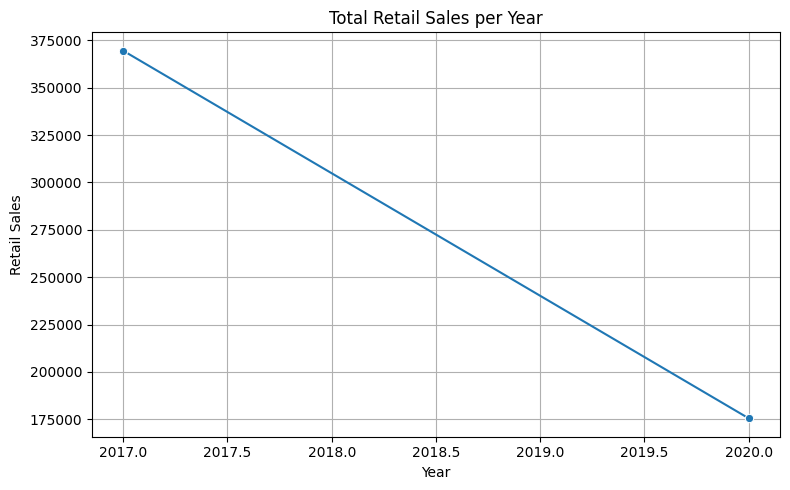

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

df1 = agg1.toPandas().sort_values("year")

plt.figure(figsize=(8, 5))
sns.lineplot(data=df1, x="year", y="total_retail_sales", marker="o")
plt.title("Total Retail Sales per Year")
plt.xlabel("Year")
plt.ylabel("Retail Sales")
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-65-ae25b671a470>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df3, x="item_code", y="total_warehouse_sales", palette="viridis")


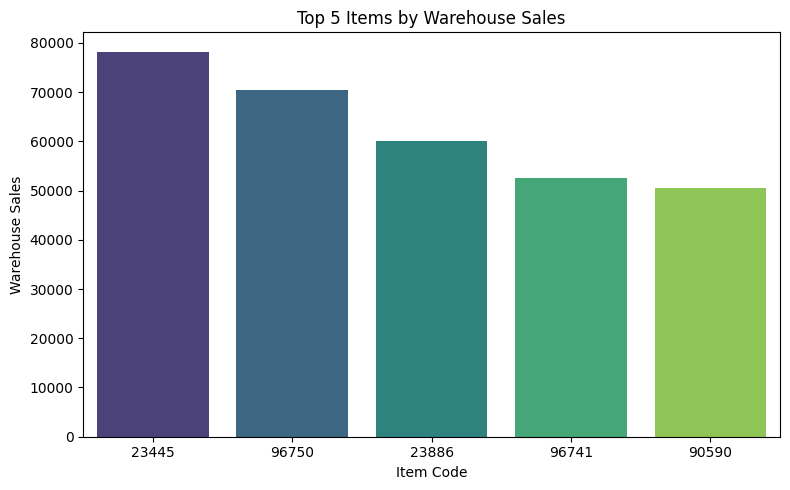

In [65]:
df3 = agg3.toPandas()

plt.figure(figsize=(8, 5))
sns.barplot(data=df3, x="item_code", y="total_warehouse_sales", palette="viridis")
plt.title("Top 5 Items by Warehouse Sales")
plt.xlabel("Item Code")
plt.ylabel("Warehouse Sales")
plt.tight_layout()
plt.show()

<ipython-input-66-4a4114700d58>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df4, x="avg_retail_transfers", y="item_type", palette="magma")


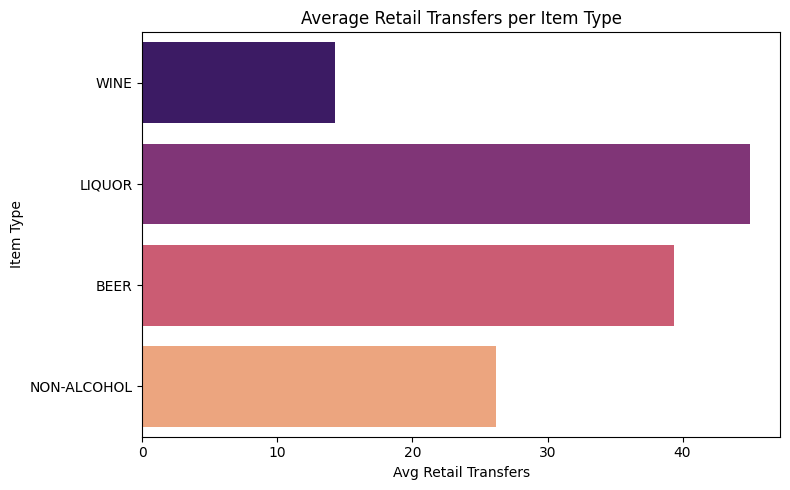

In [66]:
df4 = agg4.toPandas()

plt.figure(figsize=(8, 5))
sns.barplot(data=df4, x="avg_retail_transfers", y="item_type", palette="magma")
plt.title("Average Retail Transfers per Item Type")
plt.xlabel("Avg Retail Transfers")
plt.ylabel("Item Type")
plt.tight_layout()
plt.show()


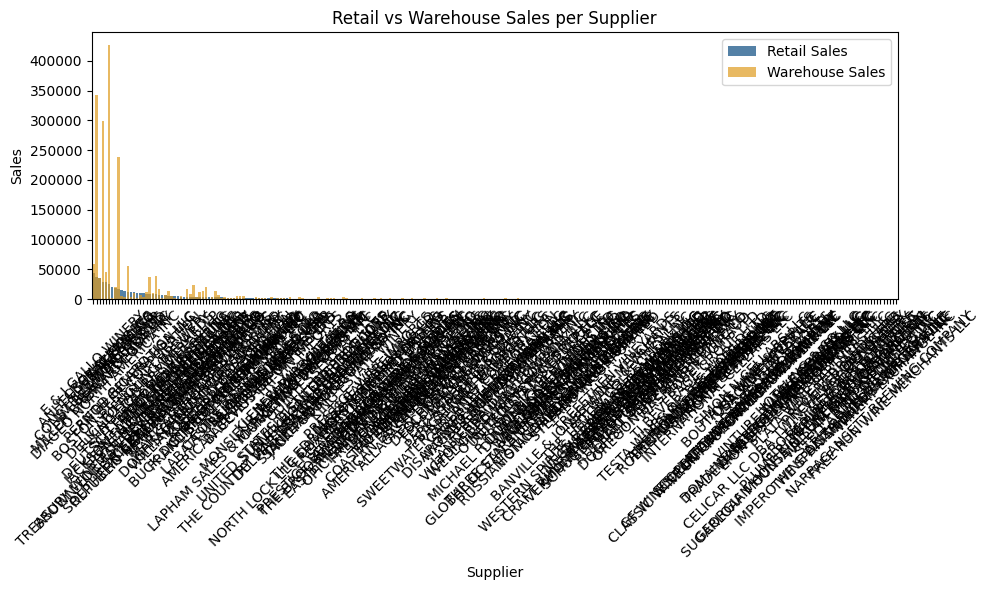

In [67]:
df5 = agg5.toPandas().sort_values("total_retail_sales", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=df5, x="supplier", y="total_retail_sales", color="steelblue", label="Retail Sales")
sns.barplot(data=df5, x="supplier", y="total_warehouse_sales", color="orange", label="Warehouse Sales", alpha=0.7)
plt.title("Retail vs Warehouse Sales per Supplier")
plt.xlabel("Supplier")
plt.ylabel("Sales")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-68-51c88c641b10>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df6, x="item_type", y="item_type_count", palette="coolwarm")


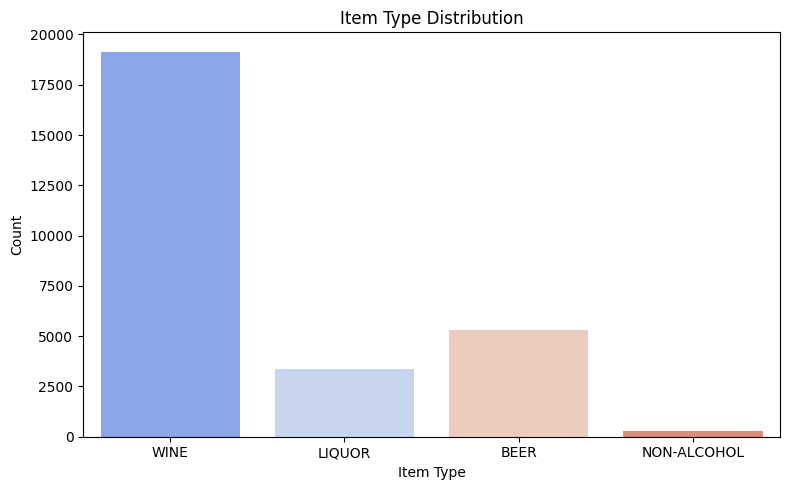

In [68]:
df6 = agg6.toPandas()

plt.figure(figsize=(8, 5))
sns.barplot(data=df6, x="item_type", y="item_type_count", palette="coolwarm")
plt.title("Item Type Distribution")
plt.xlabel("Item Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


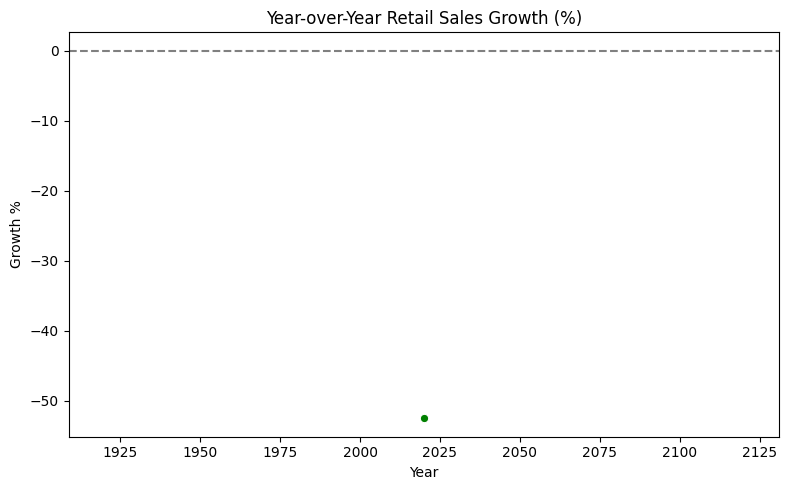

In [69]:
df7 = agg7.toPandas().sort_values("year")

plt.figure(figsize=(8, 5))
sns.lineplot(data=df7, x="year", y="growth_percentage", marker="o", color="green")
plt.title("Year-over-Year Retail Sales Growth (%)")
plt.xlabel("Year")
plt.ylabel("Growth %")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


In [75]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

# Select and cast required columns
ml_df = silver_df.select(
    col("retail_sales").cast(DoubleType()),
    col("warehouse_sales").cast(DoubleType()),
    col("retail_transfers").cast(DoubleType()),
    col("month").cast(DoubleType()),
    col("year").cast(DoubleType())
).dropna()




In [76]:
from pyspark.ml.feature import VectorAssembler

# Assemble features
assembler = VectorAssembler(
    inputCols=["warehouse_sales", "retail_transfers", "month", "year"],
    outputCol="features"
)

data = assembler.transform(ml_df).select("features", "retail_sales")


In [77]:
from pyspark.ml.regression import LinearRegression

# Train/Test split
train, test = data.randomSplit([0.8, 0.2], seed=42)

# Model
lr = LinearRegression(featuresCol="features", labelCol="retail_sales")
model = lr.fit(train)

# Predict
predictions = model.transform(test)
predictions.select("retail_sales", "prediction").show(5)


+------------+-------------------+
|retail_sales|         prediction|
+------------+-------------------+
|        0.66|-2.4462893633160547|
|       11.66|-1.0435360170114336|
|        0.32| -0.413285919080181|
|        1.46|-0.5723810849585789|
|        0.56|0.13888466725279613|
+------------+-------------------+
only showing top 5 rows



In [78]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="retail_sales", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Root Mean Squared Error (RMSE): 8.94
